# Anomaly Detection

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

Anomaly detection methods are a particular domain inside the Machine Learning domain where we try to detect Outliers in the data (i.e. samples that do not follow the data distribution). There are different scenarios: 

- Data is unlabelled and therefore we have to use unsupervised methods.
- Data is labelled but there are just a few anomaly examples to model them as a class. Thus we try to model the _normal behavior_
- We have a few labels and therefore we can use semi-supervised methods. 

In the following excercise we provide a small dataset for the Kettle with one single feature: the time of inactivity (i.e. the running time since we have seen the last connection for this appliance.)

The data is labelled and can be seen in the following graph: 

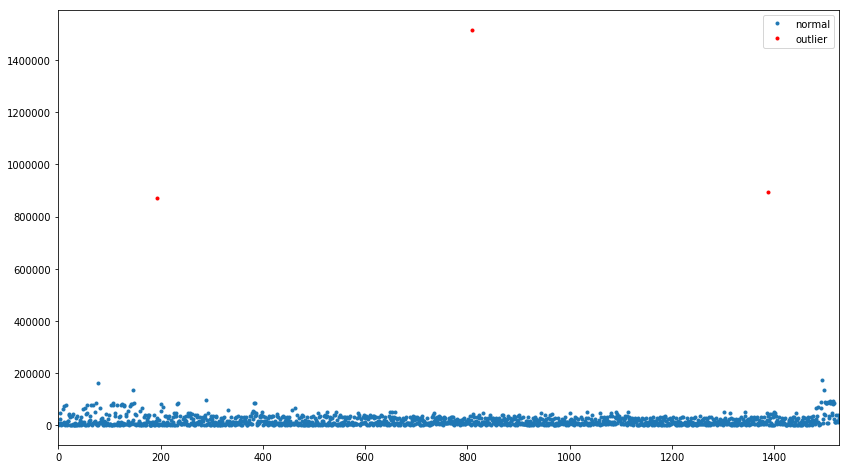

In [2]:
events = pd.read_csv('/Users/carlatroyas/Documents/Informetis/minipaperwork_data_scientist/events.csv', index_col=0)

fig, ax = plt.subplots(figsize=(14,8))
events[events.anomaly==0].inactivity.plot(style='.', ax=ax)
events[events.anomaly==1].inactivity.plot(style='.', ax=ax, color='r')
plt.legend(['normal', 'outlier'])

Your task in this excercise is to come up with an Anomaly Detector algorithm that help us to detect those cases where the Kettle has not been used for a long time. This is a very important feature for Assisted Living applications. 

Ideally this will be an unsupervised method. However, you can also come up with another supervised method as the dataset is labelled. 

__In this excercise we do not require to write any code. You can simply explain your approach in the following cells. However, any attempt to code the algorithm will be positively considered__

### Your approach: 

__Your Explanation Here__:<br>

### Introduction

Initial considerations based on the visulization of the data provided:

- Data is 1D (i.e. one feature)
- We are dealing with point anomalies, which means that a single instance of data is too far off from the rest. (Note that point anomalities differ from contextual or collective anomalities, which are context specific. For this case, we would be required to consider a set of data instances to detect an anomaly).
- A first glance at the data shows that anomalies are rare, accounting for <0.2% of the data.
- The data provided is not a time-series data, but a collection of observations.
- The dataset can be effectively split into two classes: Class 1 being a "normal" datapoint and Class 2 being an "anomaly". Thus to differentiate between the two classes both, classification and clustering methods, will be explored in this investigation. In addition, given the few number of anomalies, further methods aimed at modelling the _normal behaviour_ of the data have been considered.

I will be discussing and implementing various anomaly detection algorithms: 
1. Random Forest classifier: Supervised learning
2. K-means clustering: Unsupervised learning
3. Density-based clustering (DBSCAN): Unsupervised learning
4. GaussianMixture Clustering (Distributional-based): Unsupervised learning
5. RANSAC: Unsupervised learning
6. Moving average detector (For reference only: an implementation of a statistical approach)

Finally, I conclude with a general discussion of other approaches which may show a promising performance if the dimensionality of the data is increased (SVM for supervised learning) or if the the data under consideration is a time-series (LSTM Networks) instead of a collection of events.


### 1. Random Forest classifier: Supervised learning

In this section I implement a supervised Machine Learning model based on Random Forests. The random forests model is an ensemble method, aggregating a group of decision trees into an ensemble. Ensemble learning allows to combine several models to solve a single prediction problem. It generates multiple classifiers which learn and make predictions independently of whether a give datapoint is "normal" or "anomaly". The predictions are then combined into a single prediction. Unlike single deicison tree, which may suffer from high variance or high bias, Random Forests use averaging to find a balance between the two extremes.

The principal steps taken are: 1) Building the clasification model, 2) Training the model, 3) Testing the model, 4) Performance evaluation using various metrics to test its generalisation ability. 

In [3]:
## START CODE HERE (undefined number of lines) ##
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics

events = pd.read_csv('/Users/carlatroyas/Documents/Informetis/minipaperwork_data_scientist/events.csv', index_col=0)
data=pd.DataFrame(events)
data.head()
data_ar = np.array(data)

## END CODE HERE ##

/Users/carlatroyas/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


To use different datasets for training and testing I split the dataset provided for the kettle into two disjoint sets: train and test using the ```train_test_split()``` function

In [4]:
X = data_ar[:, 0].reshape(-1, 1) # features
y = data_ar[:, 1] # labels indicating if nomrmal or anomaly
print(X.shape)
print(y.shape)

# Split into training and test sets
XTrain, XTest, yTrain, yTest = train_test_split(X, y, random_state=9)


(1528, 1)
(1528,)


In [5]:
# Build a Random Forest classifier with 5 decision trees
rf = RandomForestClassifier(n_estimators=5, random_state=1)

# Train model
rf.fit(XTrain, yTrain)

# Make predictions of test dataset
predRF = rf.predict(XTest)

# Reports on the precision, recall and F1 scores, as well as on the overall accuracy

print(metrics.classification_report(yTest, predRF))
print("Overall Accuracy:", round(metrics.accuracy_score(yTest, predRF),2))

             precision    recall  f1-score   support

        0.0       1.00      1.00      1.00       381
        1.0       1.00      1.00      1.00         1

avg / total       1.00      1.00      1.00       382

('Overall Accuracy:', 1.0)


The classification achieves an accuracy of 1.0 for the unseen test dataset. It has correctly detected one anomaly amongs the samples provided. The 1.0 value given for precision, recall and F1 score further highlight the optimal performance of the classifier. This suggests that classification using Random Forests performs well in the detection of anomalies for data collected from Assisted living applications (given there exists enough labelled data for training). Note that for the implementation of this method we have required the use of labels for the training of the classifier. In later sections we explore the methods based on unsupervised learning.

_Additional considerations:_ We can attempt to perform a grid search to optimise the hyperparameters of the model, aimed at increase its overall performance. Of interest is to know the optimal number of decision trees to use (i.e. n_estimators)

In [6]:
from sklearn.grid_search import GridSearchCV

# Conduct a grid search with 5-fold cross-validation using the dictionary of parameters
# Parameters to investigate include:
n_estimators = np.arange(1, 30, 1) # i.e. the number of decision trees
max_depth    = np.arange(1, 20, 5)
# percentage of features to consider at each split
max_features = np.linspace(.1, 1.,1)
parameters   = [{'n_estimators': n_estimators,
                 'max_depth': max_depth,
                 'max_features': max_features}]

gridCV = GridSearchCV(RandomForestClassifier(), param_grid=parameters, cv=5, n_jobs=4)
gridCV.fit(XTrain, yTrain)

# Print the optimal parameters
best_n_estim      = gridCV.best_params_['n_estimators']
best_max_depth    = gridCV.best_params_['max_depth']
best_max_features = gridCV.best_params_['max_features']

print ('Best parameters: n_estimators=', best_n_estim,
       'max_depth=', best_max_depth,
       'max_features=', best_max_features)

/Users/carlatroyas/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)
/Users/carlatroyas/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:553: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of labels for any class cannot be less than n_folds=5.
  % (min_labels, self.n_folds)), Warning)


('Best parameters: n_estimators=', 2, 'max_depth=', 1, 'max_features=', 0.10000000000000001)


Note 1:  by default gridsearchCV parameter search is using the overall accuracy as the metric in classification. Since the problem under consideration (classifying the kettle time of inactivity) can be regarded an example of imbalanced classification, due to the low number of anomalies, alternative scoring functions should be further explored as the overall accuracy score may be misleading. It would be interesting to further explore the option of weighting classes. Also note that the value obtained for ```n_estimators``` varies, which is due to the use of a random seed in the sampling of data by the RandomForestClassifier. (The random forest algorithm itself uses a random generator to select subsets of the training data). However, the range is between 3-15, and all options give an accuracy of 1.0. Max-depth is always 1, as expected, since it is a binary clasification.

Note 2: The method of grid_search can be applied to many ML algorithms requiring the fitting of hyperparameters. 

Note 3: The dataset provided only has a single feature per event (i.e. time of inactivity). Random forests generalize well if we wish to consider additional features (higher dimensional data)



### 2. K-means: Unsupervised learning

K-means clustering is a unsupervised learning algorithm for finding clusters in a set of unlabelled data. The advantage of using this method is that we already know that our data has two clusters: a dominant cluster enclosing the "normal" datapoints, and a second one enclosing the "anomalies". Thus K=2. The centres of these clusters are found via an iterative scheme until convergence is reached. I implemented this algorithm using ```KMeans()``` from ```sklearn.cluster```. The ```.fit()``` method adapts the cluster centres, and the ```.predict()``` method can be used to determine how the trained model classifies data (if the data has sucessfully been separated into "normal" and "anomaly"). The assumption when using density-based clustering algorithms for anomaly detection is that the normal data points occur around a dense neighbourhood and abnormalities are far away. This is the case in our data, hence the K-means algorithm has the potential to perform well for the detection of anomalies in our dataset.

In [7]:
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import silhouette_score

# Apply k-means with 2 clusters
df=pd.DataFrame(events)
X=df['inactivity'].values.reshape(-1, 1)
y=df['anomaly'].values

n_clusters=2

#fit model
kmeans = KMeans(n_clusters = n_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [11]:
# use the fitted model to predict whether a datapoint is normal or an anomaly
cluster_assignment = kmeans.predict(X)
set(cluster_assignment)

#calculate accuracy
print("Overall Accuracy:", round(metrics.accuracy_score(y, cluster_assignment),2))

('Overall Accuracy:', 1.0)


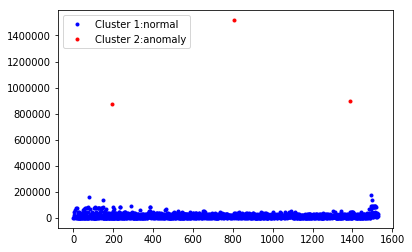

In [12]:
#plot the results results
plt.plot(np.array(np.where(cluster_assignment==0)).reshape((X[cluster_assignment==0].size,1)), X[cluster_assignment==0], 'b.', np.array(np.where(cluster_assignment==1)).reshape((X[cluster_assignment==1].size,1)), X[cluster_assignment==1], 'r.')
plt.legend(['Cluster 1:normal', 'Cluster 2:anomaly'])

The data has been succesfully split into two clusters: the nomal data and the anomalies, which an overall accuracy of 1.0. Thus we conclude that the K-means algorithm performs well for solving the problem of anomaly detection in the dataset provided.

__Analysis of the model__: 

1. We can look at the centroids of the clusters to intuitively check that they are correctly indicating the approximate location of the normal datapoints and the anomalies.

2. We can compute the silhouette score, which represents how similar a sample is to the samples in its own cluster compared to samples in other clusters.

In [13]:
print('Cluster centroids: ', kmeans.cluster_centers_)
print('Silhoutte score: ', metrics.silhouette_score(X, cluster_assignment))

('Cluster centroids: ', array([[   16861.63934426],
       [ 1094140.66666667]]))
('Silhoutte score: ', 0.98274201822626206)


The cluster centroids are resonable. For the silhoutte score, the best value is 1 and the worst -1. (Values near 0 indicate overlapping clusters). The computed silhoutte score is very high (0.98). Thus this classification method shows a high performance in differentiating between the points belonging to the normal and to the anomaly class. Note: Since our data is 1D the clusters are described by 1D Gaussians, thus having a scalar variance.

__K-Means pros__

- Fast. The real-world datasets collected for the different Assisted Living applications can be very large, thus K-Means is a good option to cluster out the anomalies.
- Prior knowledge: we already know that the number of clusters in the dataset is 2 (normal and anomaly)
- K-Mean generalizes well for the use of several features (higher dimensional data), normalization of the features before running the clustering algorithm would be recomended in order to obtain similar scales for the different dimensions.


### 3. Density-based clustering (DBSCAN): Unsupervised learning

In this section I implement an unsupervised anomaly detection algorithm based on density based clustering. The DBSCAN algorithm views clusters as areas of high density separated by areas of low density. In general, the main difference beween DBSCAN and the K-Means algorithm is that the clusters found by DBSCAN can be any shape, as opposed to k-means which assumens that clusters are convex shaped. However, since our data only has a single feature (1D) this may not prove to be an advantage. The two parameters to the algorithms: ```min_samples``` and ```eps```, define the "density" of the clusters, i.e. high ```min_samples``` or low ```eps``` indicate a higher density is necessary to form a cluster.

In [14]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# normalisation of the data for optimal performance of the algorithm
Xo = StandardScaler().fit_transform(X) 

# Compute DBSCAN (fit the model to the training data)

# with these hyperparameters the anomalies are detected as a separate cluster (the normal datapoints form their own cluster):
#db = DBSCAN(eps=12, min_samples=2).fit(Xo) 

# with these hyperparameters the anomalies are detected as noise (the normal datapoints form their own cluster):
# subsequently the noise can be considered an "additional class" containing the anomalies
db = DBSCAN(eps=5, min_samples=10).fit(Xo) 

core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels
n_clusters_ = len(set(labels))

#plt.plot(labels, 'o')

print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, labels))
print("Completeness: %0.3f" % metrics.completeness_score(y, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(y, labels))
print("Adjusted Rand Index: %0.3f" % metrics.adjusted_rand_score(y, labels))
print("Adjusted Mutual Information: %0.3f" % metrics.adjusted_mutual_info_score(y, labels))
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(X, labels))

Estimated number of clusters: 2
Homogeneity: 1.000
Completeness: 1.000
V-measure: 1.000
Adjusted Rand Index: 1.000
Adjusted Mutual Information: 1.000
Silhouette Coefficient: 0.983


In [15]:
print(set(labels))
labels[labels==-1]=1

#calculate accuracy
print("Overall Accuracy:", round(metrics.accuracy_score(y, labels),2))

set([0, -1])
('Overall Accuracy:', 1.0)


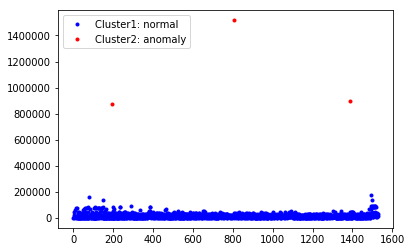

In [16]:
plt.plot(np.array(np.where(labels==0)).reshape((X[labels==0].size,1)), X[labels==0], 'b.', np.array(np.where(labels==1)).reshape((X[labels==1].size,1)), X[labels==1], 'r.')
plt.legend(['Cluster1: normal', 'Cluster2: anomaly'])

__Considerations__

- this approach requires the tunning of the hyperparameters (`eps` and `min_samples`). For this first implementation I have tuned these parameters manually. Optimally, a gridsearch for both parameters should be performed using the labels availabe (i.e. semi-supervised learning).


__Note for clustering methods__

- In general, if we only have a few labels we can use semisupervisor learning to optimise the quality of the clustering. In other words, we perform clustering for the whole data (unsupervised), and then evaluate the accuracy of the classifier (with the use of adequate metrics) using the labelled data by performing a hyperparameters search (supervised).

###  4. Gaussian Mixture Model: Unsupervised learning



The `GaussianMixture` object implements the expectation-maximization algorithm for fitting mixture-of-Gaussian models. It computes the Bayesian Information Criterion to assess the number of clusters in the data. The `GaussianMixture.fit` method learns a Gaussian Mixture Model from the training data. Given the test data, the model then assigns to each sample the Gaussian to which it most probably belong to (the one giving the highest probability for generating the sample) using the `GaussianMixture.predict` method.

I specify that the data should be described by a mixture of 2 Gaussian (`n_components=2`), since intuitively I want the first components to be fitted to the normal datapoints and the second to the anomalies. 

In [17]:
from sklearn.mixture import GaussianMixture

# create model
g = GaussianMixture(n_components=2, covariance_type='spherical').fit(X)

# fit model
cluster_assignment_GMM = g.predict(X)

In [18]:
#print('Estimated number of clusters: %d' % n_clusters_)
print("Homogeneity: %0.3f" % metrics.homogeneity_score(y, cluster_assignment_GMM))
print("Completeness: %0.3f" % metrics.completeness_score(y, cluster_assignment_GMM))
print("V-measure: %0.3f" % metrics.v_measure_score(y, cluster_assignment_GMM))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(y, cluster_assignment_GMM))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(y, cluster_assignment_GMM))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, y, metric='sqeuclidean'))

Homogeneity: 0.463
Completeness: 0.042
V-measure: 0.078
Adjusted Rand Index: 0.097
Adjusted Mutual Information: 0.041
Silhouette Coefficient: 0.999


In [19]:
print(set(cluster_assignment_GMM))

set([0, 1])


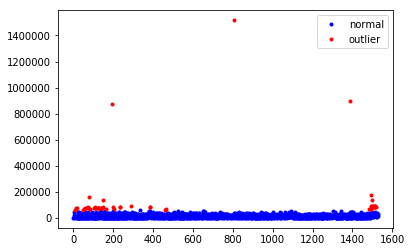

In [20]:
plt.plot(np.array(np.where(cluster_assignment_GMM==0)).reshape((X[cluster_assignment_GMM==0].size,1)), X[cluster_assignment_GMM==0], 'b.', np.array(np.where(cluster_assignment_GMM==1)).reshape((X[cluster_assignment_GMM==1].size,1)), X[cluster_assignment_GMM==1], 'r.')
plt.legend(['normal', 'outlier'])

As observed from the plot, the results from this implementation are insatisfactory. The model consists of two Gaussians: The first describes the majority of the normal points. However, during the fitting of the model, the variance of the second component appears to have grown sufficiently large to englobe under its distribution some of the normal datapoints with higher values. This results in the incorrect prediciton of outliers. Thus the K-means algorithm can be regarded as superior for the anomaly detection problem under consideration. An alternative approach is to implement a GMM algorithm directly and experiment with different initializations for the mean, std dev and prior of the components which may result in an increase of the overall performance.

### 5. RANSAC: Unsupervised learning

In this section I have implemented RANSAC (Random sample concensus), an iterative method used for estimating the parameters of a mathematical model describing a set of observed data which contains outliers. The fundamental idea behind this approach is as follows: 

1. Iterate by fitting the model being considered to several random samplings of the data until the majority of the data samples are classified as 'inliers'.
2. Once the optimal parameters of the model have been found giving the largest number of inliers above the specified threshold (i.e. those parameters which best decribe the dominant or normal behaviour of the data) the points regarded as outliers are classified as the anomalies of the dataset. 

RANSAC is most commonly used to fit a linear model to the data and subsequently calculated the distance of the samples to the line. However, the "Kettle data" is 1D, so I have chosen a 1D Gaussian distribution as the mathematical model to decribe the normal behaviour of the data. The parameters to be fitted are the mean and the standard deviation. A metric which considers the distance of a sample to the centre of the distribution is then used to determine whether the sample is an "inlier" or an "oulier".

In [21]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import math
import sys
import scipy.stats

# Ransac parameters
ransac_iterations = 20  # number of iterations
ransac_ratio = 0.9      # ratio of inliers required to assert that a model fits well to data
n_samples =  X.size     # number of input points 


In [22]:
# model describing the data

def find_gaussian(maybe_points):
    
    mean_o= maybe_points.mean()
    std_o=maybe_points.std()
    
    return mean_o, std_o

In [23]:
# self-defined metric to determine distance of datapoint to the gaussian distribution 
# (this metric is what will be used to differentiate between a normal and an anomaly point)

def find_metric(point, mean_o, std_o):
    
    metric = np.abs(point-mean_o)/std_o
    
    return metric

In [24]:
# perform RANSAC iterations

for it in range(ransac_iterations):

    # pick up random points to fit model (determine mean and std dev)
    n = 100

    all_indices = np.arange(X.shape[0])
    np.random.shuffle(all_indices)

    indices_1 = all_indices[:n]
    indices_2 = all_indices[n:]

    maybe_points = X[indices_1,:]
    test_points = X[indices_2,:]

    # find distribution for these points
    mean_o, std_o = find_gaussian(maybe_points)

    x_list = []   # list to contain all "normal" samples
    x_list_anomalies = []   # list to contain all "anomalies"
    
    num = 0 
    num_anomalies = 0

    # find probabilities for all testing points
    for ind in range(test_points.shape[0]):

        x0 = test_points[ind]

        # find metric 
        metric = find_metric(x0, mean_o, std_o)

        # check whether it's an inlier or not (i.e. whether the datapoint belongs to the dominant "normal class")
        if metric < 30:
            x_list.append(x0)
            num += 1
        else:
            x_list_anomalies.append(x0)
            num_anomalies += 1

    x_inliers = np.array(x_list)

    # in case a new model is better - cache it
    if num/(float(n_samples)-n) > ransac_ratio:
        ratio = num/float(n_samples)
        model_mean = mean_o
        model_std = std_o

        #print ('  inlier ratio = ', num/(float(n_samples)-n))
        #print ('  model_mean = ', model_mean)
        #print ('  model_std = ', model_std)

    
    # we are done in case we have enough inliers
    if num > n_samples*ransac_ratio:
        print ('The model is found !')
        break

print ('\nFinal model:\n')
print ('  ratio = ', num/(float(n_samples)-n))
print ('  model_mean = ', model_mean)
print ('  model_std = ', model_std)



The model is found !

Final model:

('  ratio = ', 0.9978991596638656)
('  model_mean = ', 17183.529999999999)
('  model_std = ', 17583.20618570743)


In [26]:
#predicted anomalies from dataset

print(num_anomalies)
x_list_anomalies

3


[array([ 894010.]), array([ 1516827.]), array([ 871585.])]

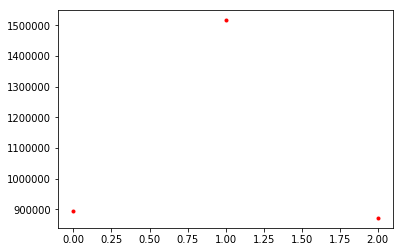

In [27]:
#plot the anomalies

plt.plot(x_list_anomalies, 'r.')

The algorithm has detected the three anomalies. Further work on this method could involve investigating the use of other mathematical models describing the data and metrics to classify samples into "inliers" and "ouliers"

### 6. Moving average detector (statistical method)


The aim in this method is to identify irregularities in the data: i.e. to flag data points that deviate from common statistical properties of the distribution (mean and std dev)

Since the mean over the event-series data may not be static it is safer to use a rolling window to compute the average across a subset of data points.

In [28]:
from __future__ import division
from itertools import izip, count
import matplotlib.pyplot as plt
from numpy import linspace, loadtxt, ones, convolve
import collections
from random import randint
%matplotlib inline

In [29]:
# Reload dataset file (just to be safe)
datafile = 'events.csv'

df = pd.read_csv(datafile, index_col=0); df.index.name = 'Events'
df.head()

,inactivity,anomaly
Events,,
0,897.0,0
1,3887.0,0
2,9269.0,0
3,23023.0,0
4,46943.0,0


In [30]:
def moving_average(data, window_size):
    window = np.ones(int(window_size))/float(window_size)
    return np.convolve(data, window, 'same')

def explain_anomalies(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size).tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    std = np.std(residual)
    return {'standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i) for
                                                       index, y_i, avg_i in izip(count(), y, avg)
              if (y_i > avg_i + (sigma*std)) | (y_i < avg_i - (sigma*std))])}

def explain_anomalies_rolling_std(y, window_size, sigma=1.0):
    avg = moving_average(y, window_size)
    avg_list = avg.tolist()
    residual = y - avg
    # Calculate the variation in the distribution of the residual
    testing_std = pd.rolling_std(residual, window_size)
    testing_std_as_df = pd.DataFrame(testing_std)
    rolling_std = testing_std_as_df.replace(np.nan,
                                  testing_std_as_df.ix[window_size - 1]).round(3).iloc[:,0].tolist()
    std = np.std(residual)
    return {'stationary standard_deviation': round(std, 3),
            'anomalies_dict': collections.OrderedDict([(index, y_i)
                                                       for index, y_i, avg_i, rs_i in izip(count(),
                                                                                           y, avg_list, rolling_std)
              if (y_i > avg_i + (sigma * rs_i)) | (y_i < avg_i - (sigma * rs_i))])}


def plot_results(x, y, window_size, sigma_value=1,
                 text_xlabel="X Axis", text_ylabel="Y Axis", applying_rolling_std=False, xlim=1000):
    
    plt.figure(figsize=(15, 8))
    plt.plot(x, y, "k.", label='normal')
    y_av = moving_average(y, window_size)
    plt.plot(x, y_av, color='green', label='Moving average')
    plt.xlim(0, xlim)
    plt.xlabel(text_xlabel)
    plt.ylabel(text_ylabel)
    #plt.legend('Moving average')

    events = {}
    if applying_rolling_std:
        events = explain_anomalies_rolling_std(y, window_size=window_size, sigma=sigma_value)
    else:
        events = explain_anomalies(y, window_size=window_size, sigma=sigma_value)

    x_anomaly = np.fromiter(events['anomalies_dict'].iterkeys(), dtype=int, count=len(events['anomalies_dict']))
    y_anomaly = np.fromiter(events['anomalies_dict'].itervalues(), dtype=float,
                                            count=len(events['anomalies_dict']))
    plt.plot(x_anomaly, y_anomaly, "r.", markersize=12, label='anomaly')

    plt.grid(True)
    plt.legend()
    plt.show()
    
x = df.index
Y = df['inactivity']

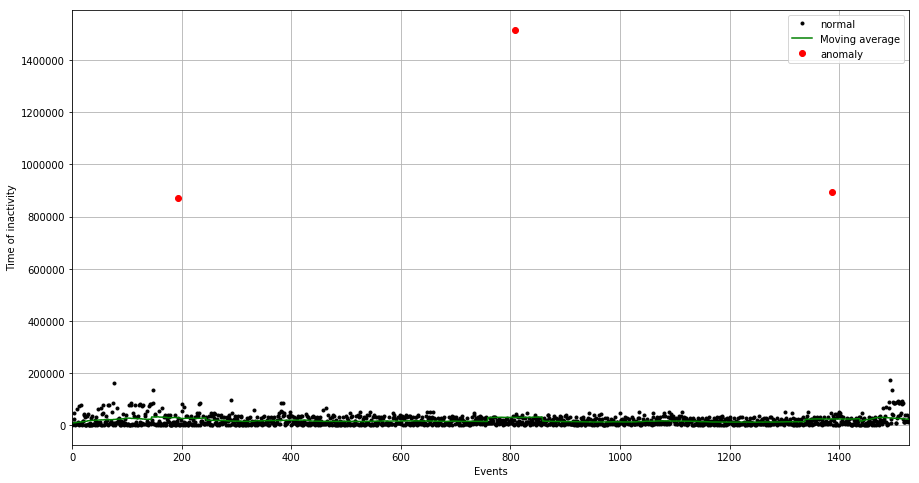

Information about the anomalies model:{'anomalies_dict': OrderedDict([(194, 871585.0), (808, 1516827.0), (1387, 894010.0)]), 'standard_deviation': 52407.613}


In [31]:
# plot the results
plot_results(x, y=Y, window_size=100, text_xlabel="Events", sigma_value=3,
             text_ylabel="Time of inactivity", xlim=len(df.index))
events = explain_anomalies(Y, window_size=100, sigma=3)

# Display the anomaly dict
print("Information about the anomalies model:{}".format(events))

### Additional considerations/algorithms

#### Supervised Method

_SVM_

For the detection of anomalies a One-class SVM could be used. However its implementation for 1D data is not very meaningful, since it would just result in single "1D-threshold line" about half the distance between the anomalies and the normal  samples that separates the data. Thus instead of training a SVM it would be simpler to implement a direct threshold determined to be half way between the mean of the normal samples and that of the anomalies for instance. However, if additional features are to be considered, a SVM can potentially do very well at discriminating between inliers and outliers. Note however that labelled data is required to train the SVM!

#### Unsupervised Method

_Maximum Likelihood Gaussian_

A further approach which can be considered consists in fitting a probability distribution to the data to model its _normal behaviour_ . Optimally, this distribution should describe the "normal" behviour of the data. If I was to take a "supervised learning approach", we could make use of the datapoints with label=0 only to find the parameters of such distribution.

However, it can also be implemented as an unsupervised learning method. Since the number of anomalies is <0.5% of the total dataset, the gaussian should only be slightly skewed and should still be heavily dominated by the nomal datapoints. 

The main steps would be as follows: 
1. Split dataset into training and testing.
2. Compute the average and std of the training data. 
3. Make predictions on the test dataset: For each sample, determine whether it is an inlier (normal point) or an outlier (anomaly). This can be done by calculating the likelihood of the given sample (or its posterior probability) given the parameters of the distribution. 
4. A very low likelihood would indicate an anomaly


_LSTM Neural Networks for time-series anomaly detection_

If the data was to be a time series (eg. power consumption with time instead of a collection of events) we could implement a LSTM. The assumption when implementing this model is that the normal time-series is predictable to some extent. Thus the network can be used as a prediction model: 

1. Given current and past values, the network can predict the next few steps in the time series. 
2. The error in prediction is then computed by considering the true sample: error = abs(predicted_value-actual_values)
3. If the prediction error is high, it indicates an anomaly

Otherwise an LSTM could be used directly as a classifier with two classes: normal and anomalous. However, its training requires labelled data, and we have already observed a good performance using random forests, thus implementing a NN for classification is rebundant.

### Conclusions

In summary, the best algorithms for the dataset provided have proven to be:

1. For supervised learning: Decision Trees / Random Forests
2. For unsupervised learning: I would go for K-Means because it is the simplest and we can directly input the number of clusters expected (i.e. 2). However other algorithms such as RANSAC and DBSCAN have also shown good performance, and the hyperparameters can be chosen using grid search in a semisupervised learning fashion.